<a href="https://colab.research.google.com/github/jejjohnson/gp_model_zoo/blob/master/code/numpyro/numpyro_sparsegp_uncertain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sparse Gaussian Process w/ Numpyro

My starting notebook where I install all of the necessary libraries and load some easy 1D/2D Regression data to play around with.

In [1]:
# #@title Install Packages
# %%capture
# !pip install jax jaxlib chex optax loguru
# !pip install "git+https://github.com/pyro-ppl/numpyro.git#egg=numpyro"
# !pip uninstall tensorflow -y -q
# !pip install -Uq tfp-nightly[jax] > /dev/null

In [2]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".root"])

# append to path
sys.path.append(str(root))

In [3]:
# @title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# JAX SETTINGS
import jax
import jax.numpy as jnp
import jax.random as random


# JAX UTILITY LIBRARIES
import chex

# NUMPYRO SETTINGS
import numpyro
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro.infer import SVI, Trace_ELBO

# NUMPY SETTINGS
import numpy as np

np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns

sns.set_context(context="talk", font_scale=0.7)

# PANDAS SETTINGS
import pandas as pd

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import loguru

%load_ext lab_black
%load_ext autoreload
%autoreload 2

## Data

In [4]:
def large_sample_demo(
    n_train: int = 1_000, n_test: int = 1_000, noise: float = 0.2, seed: int = 123
):
    key = jax.random.PRNGKey(seed)

    x = jnp.linspace(-1.0, 1.0, n_train).reshape(-1, 1)  # * 2.0 - 1.0
    f = (
        lambda x: jnp.sin(x * 3 * 3.14)
        + 0.3 * jnp.cos(x * 9 * 3.14)
        + 0.5 * jnp.sin(x * 7 * 3.14)
    )

    signal = f(x)
    y = signal + noise * jax.random.normal(key, shape=signal.shape)

    xtest = jnp.linspace(-1.1, 1.1, n_test).reshape(-1, 1)
    ytest = f(xtest)
    return x, y, xtest, ytest

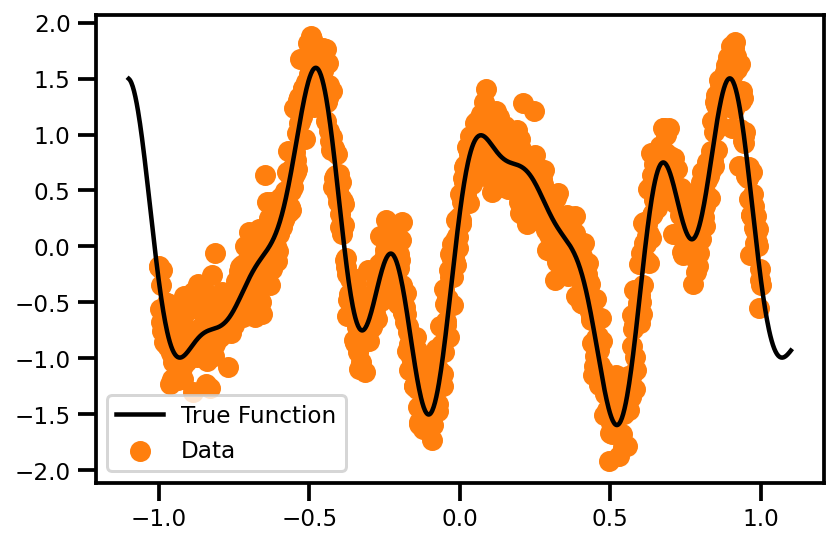

In [6]:
Xtrain, ytrain, xtest, ytest = large_sample_demo(
    n_train=1_000, n_test=1_000, noise=0.2, seed=123
)

fig, ax = plt.subplots()
ax.scatter(Xtrain, ytrain, color="tab:orange", label="Data")
ax.plot(xtest, ytest, color="black", label="True Function")
ax.legend()
plt.tight_layout()
plt.show()

## Gaussian Process Model

### Kernel Function

In [7]:
from chex import Array
from src.utils import identity_matrix, add_to_diagonal
from src.kernels import RBF

# # squared euclidean distance
# def sqeuclidean_distance(x: Array, y: Array) -> float:
#     return jnp.sum((x - y) ** 2)


# # distance matrix
# def cross_covariance(func: Callable, x: Array, y: Array) -> Array:
#     """distance matrix"""
#     return jax.vmap(lambda x1: jax.vmap(lambda y1: func(x1, y1))(y))(x)


# @struct.dataclass
# class RBF:
#     variance: Array
#     length_scale: Array

#     def cross_covariance(self, X, Y):
#         # distance formula
#         deltaXsq = cross_covariance(
#             sqeuclidean_distance, X / self.length_scale, Y / self.length_scale
#         )

#         # rbf function
#         K = self.variance * jnp.exp(-0.5 * deltaXsq)
#         return K

#     def gram(self, X):
#         return self.cross_covariance(X, X)

#     def diag(self, X):
#         return self.variance * jnp.ones(X.shape[0])

In [8]:
rbf_kernel = RBF(length_scale=1.0, variance=1.0)
K = rbf_kernel.gram(Xtrain)

# check shape
chex.assert_shape(K, (Xtrain.shape[0], Xtrain.shape[0]))

In [ ]:
fig, ax = plt.subplots()

ax.imshow(K, interpolation="nearest")
plt.tight_layout()
plt.show()

### Inducing Points

In [300]:
n_inducing = 100

#### Random Selection

In [313]:
from src.utils import init_inducing_subsample, init_inducing_kmeans

X_u_init = init_inducing_subsample(Xtrain, n_inducing, seed=42)

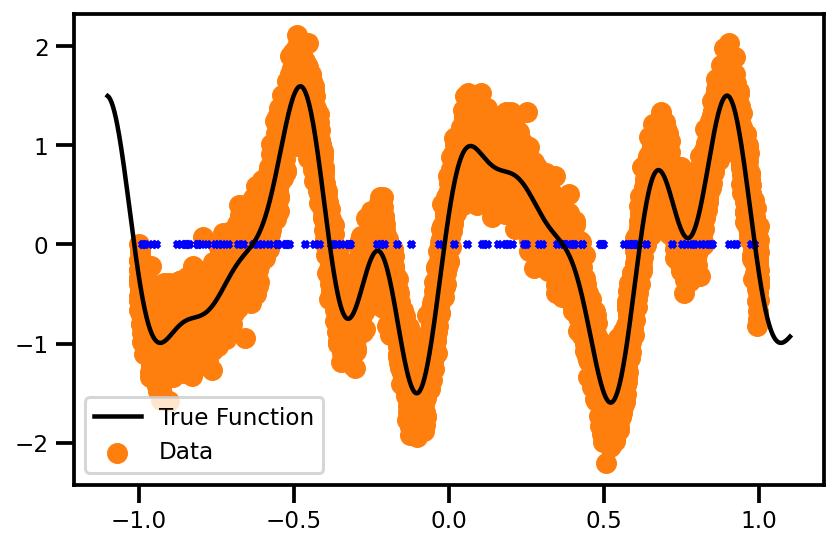

In [314]:
fig, ax = plt.subplots()
ax.scatter(Xtrain, ytrain, color="tab:orange", label="Data")
ax.plot(xtest, ytest, color="black", label="True Function")
ax.scatter(X_u_init, np.zeros(n_inducing), color="blue", marker="x", s=10)
ax.legend()
plt.tight_layout()
plt.show()

#### K-Means Clustering

In [317]:
X_u_init = init_inducing_kmeans(Xtrain, n_inducing, seed=123)

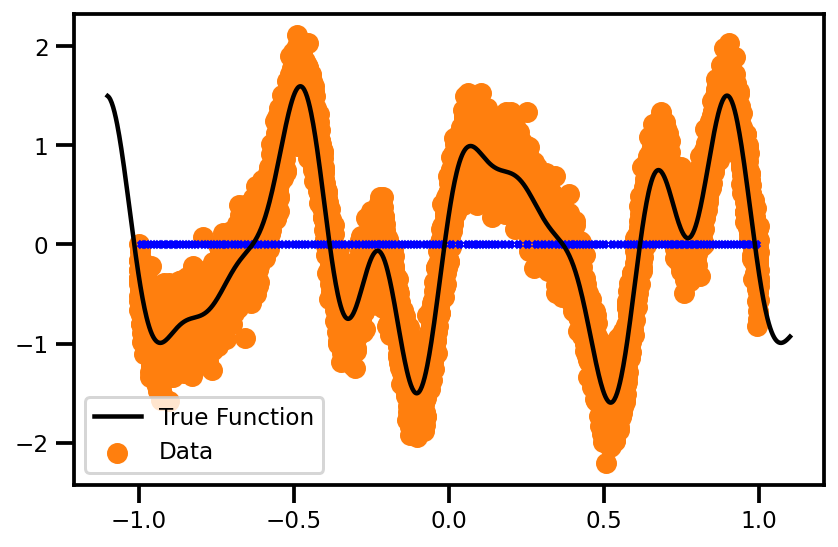

In [318]:
fig, ax = plt.subplots()
ax.scatter(Xtrain, ytrain, color="tab:orange", label="Data")
ax.plot(xtest, ytest, color="black", label="True Function")
ax.scatter(X_u_init, np.zeros(n_inducing), color="blue", marker="x", s=10)
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
from src.sparse import vfe_precompute

jitter = 1e-5


def SGP_VFE(X, y):
    n_samples = X.shape[0]

    #     # Set priors on kernel hyperparameters.
    #     η = numpyro.sample("variance", dist.HalfCauchy(scale=5.0))
    #     ℓ = numpyro.sample("length_scale", dist.Gamma(2.0, 1.0))
    #     σ = numpyro.sample("obs_noise", dist.HalfCauchy(scale=5.0))

    x_u = numpyro.param("x_u", init_value=X_u_init)

    η = numpyro.param("variance", init_value=1.0, constraints=dist.constraints.positive)
    ℓ = numpyro.param(
        "length_scale", init_value=0.1, constraints=dist.constraints.positive
    )
    σ = numpyro.param("obs_noise", init_value=0.1, onstraints=dist.constraints.positive)

    # ================================
    # Mean Function
    # ================================
    f_loc = np.zeros(n_samples)

    # ================================
    # Qff Term
    # ================================
    # W   = (inv(Luu) @ Kuf).T
    # Qff = Kfu @ inv(Kuu) @ Kuf
    # Qff = W @ W.T
    # ================================
    rbf_kernel = RBF(variance=η, length_scale=ℓ)

    Luu, W, D = vfe_precompute(X, x_u, σ, rbf_kernel, jitter=1e-5)

    #     Kuu = rbf_kernel.gram(x_u)
    #     Kuf = rbf_kernel.cross_covariance(x_u, X)
    #     # Kuu += jnp.eye(Ninducing) * jitter
    #     # add jitter
    #     Kuu = add_to_diagonal(Kuu, jitter)

    #     W, D = vfe_precompute(Kuu, Kuf, σ)

    W = numpyro.deterministic("W", W)
    D = numpyro.deterministic("G", D)

    # ================================
    # trace term
    # ================================
    # t = tr(Kff - Qff) / noise
    # t /= - 2.0
    # ================================
    gp_model = SGPVFE(X=X, y=y, X_u=x_u, kernel=rbf_kernel, obs_noise=σ)
    
    
#     Kffdiag = rbf_kernel.diag(X)
#     Qffdiag = jnp.power(W, 2).sum(axis=1)
#     trace_term = (Kffdiag - Qffdiag).sum() / σ
#     trace_term = jnp.clip(trace_term, a_min=0.0)  # numerical errors

    # add trace term to the log probability loss
    numpyro.factor("trace_term", gp_model.trace_term())

    # Sample y according SGP
    return numpyro.sample(
        "y",
        dist.LowRankMultivariateNormal(loc=f_loc, cov_factor=W, cov_diag=D)
        .expand_by(y.shape[:-1])
        .to_event(y.ndim - 1),
        obs=y,
    )


def empty_guide(X, y):
    pass

In [395]:
from src.sparse import vfe_precompute

jitter = 1e-5


def SGP_VFE(X, y):
    n_samples = X.shape[0]

    #     # Set priors on kernel hyperparameters.
    #     η = numpyro.sample("variance", dist.HalfCauchy(scale=5.0))
    #     ℓ = numpyro.sample("length_scale", dist.Gamma(2.0, 1.0))
    #     σ = numpyro.sample("obs_noise", dist.HalfCauchy(scale=5.0))

    x_u = numpyro.param("x_u", init_value=X_u_init)

    η = numpyro.param("variance", init_value=1.0, constraints=dist.constraints.positive)
    ℓ = numpyro.param(
        "length_scale", init_value=0.1, constraints=dist.constraints.positive
    )
    σ = numpyro.param("obs_noise", init_value=0.1, onstraints=dist.constraints.positive)

    # ================================
    # Mean Function
    # ================================
    f_loc = np.zeros(n_samples)

    # ================================
    # Qff Term
    # ================================
    # W   = (inv(Luu) @ Kuf).T
    # Qff = Kfu @ inv(Kuu) @ Kuf
    # Qff = W @ W.T
    # ================================
    rbf_kernel = RBF(variance=η, length_scale=ℓ)

    Kuu = rbf_kernel.gram(x_u)
    Kuf = rbf_kernel.cross_covariance(x_u, X)
    # Kuu += jnp.eye(Ninducing) * jitter
    # add jitter
    Kuu = add_to_diagonal(Kuu, jitter)

    W, D = vfe_precompute(X, x_u, Kuu, Kuf, rbf_kernel, σ, jitter=1e-5)

    # cholesky factorization
    Luu = numpyro.deterministic("Luu", cholesky(Kuu, lower=True))

    # W matrix
    W = solve_triangular(Luu, Kuf, lower=True)
    W = numpyro.deterministic("W", W).T

    # ================================
    # Likelihood Noise Term
    # ================================
    # D = noise
    # ================================
    D = numpyro.deterministic("G", jnp.ones(n_samples) * σ)

    # ================================
    # trace term
    # ================================
    # t = tr(Kff - Qff) / noise
    # t /= - 2.0
    # ================================
    Kffdiag = rbf_kernel.diag(X)
    Qffdiag = jnp.power(W, 2).sum(axis=1)
    trace_term = (Kffdiag - Qffdiag).sum() / σ
    trace_term = jnp.clip(trace_term, a_min=0.0)  # numerical errors

    # add trace term to the log probability loss
    numpyro.factor("trace_term", -trace_term / 2.0)

    # Sample y according SGP
    return numpyro.sample(
        "y",
        dist.LowRankMultivariateNormal(loc=f_loc, cov_factor=W, cov_diag=D)
        .expand_by(y.shape[:-1])
        .to_event(y.ndim - 1),
        obs=y,
    )


def empty_guide(X, y):
    pass

In [ ]:
with numpyro.handlers.seed(rng_seed=123):
    t = SGP_VFE(Xtrain, ytrain)

## Exact GP - Maximum Marginal Likelihood

In [425]:
from numpyro.infer.autoguide import (
    AutoDelta,
)  # AutoDiagonalNormal, AutoIAFNormal, AutoLaplaceApproximation, AutoMultivariateNormal

In [426]:
# ===================
# Model
# ===================
# GP model
sgp_model = SGP_VFE

# delta guide - basically deterministic
delta_guide = AutoDelta(sgp_model)
mll_guide = empty_guide

In [427]:
print(t.shape)

(10000, 1)


In [428]:
# reproducibility
rng_key = random.PRNGKey(0)


# Setup
# guide = numpyro.infer.autoguide.AutoDelta(GP)
optimizer = numpyro.optim.Adam(step_size=0.005)
# optimizer = numpyro.optim.Minimize()
# optimizer = optax.adamw(learning_rate=0.1)
svi = SVI(sgp_model, mll_guide, optimizer, loss=Trace_ELBO())
svi_results = svi.run(random.PRNGKey(1), 100, Xtrain, ytrain.T)

100%|██████████| 100/100 [00:10<00:00,  9.39it/s, init loss: -207.8288, avg. loss [96-100]: -1773.8233]


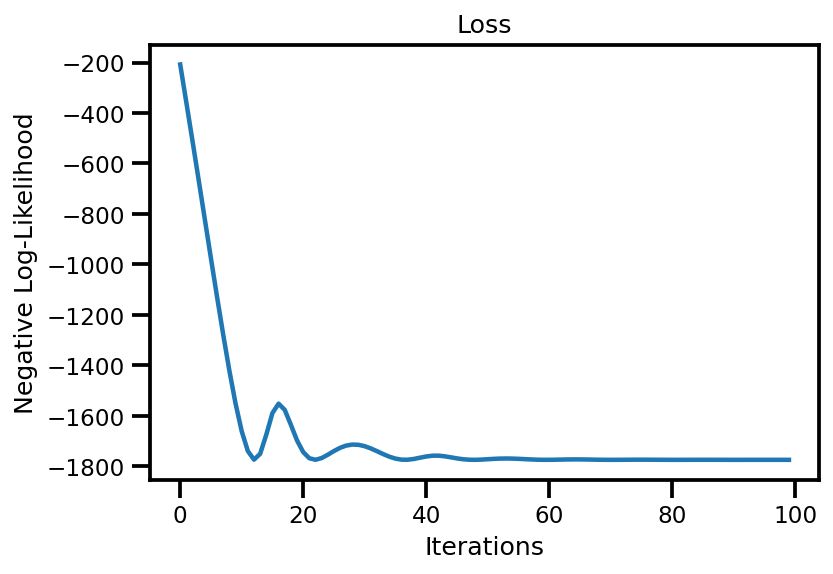

In [429]:
fig, ax = plt.subplots()

ax.plot(svi_results.losses)
ax.set(title="Loss", xlabel="Iterations", ylabel="Negative Log-Likelihood")
plt.show()

### Extracting the Params

In [430]:
from pprint import pprint

# Take them directly
learned_params = svi_results.params

## Predictions

In [442]:
def get_cond_params(
    kernel, params: dict, x: Array, y: Array, jitter: float = 1e-5
) -> dict:

    params = deepcopy(params)
    x_u = params.pop("x_u")
    obs_noise = params.pop("obs_noise")
    kernel = kernel(**params)
    n_samples = x.shape[0]

    # calculate the cholesky factorization
    Luu, W, D = vfe_precompute(x, x_u, obs_noise, kernel, jitter=jitter)

    W_Dinv = W.T / D
    K = W_Dinv @ W
    K = add_to_diagonal(K, 1.0)
    L = cholesky(K, lower=True)

    # mean function
    y_residual = y  # mean function
    y_2D = y_residual.reshape(-1, n_samples).T
    W_Dinv_y = W_Dinv @ y_2D

    return {
        "X": x,
        "y": y,
        "Luu": Luu,
        "L": L,
        "W_Dinv_y": W_Dinv_y,
        "x_u": x_u,
        "kernel_params": params,
        "obs_noise": obs_noise,
        "kernel": kernel,
    }

In [443]:
precompute_params = get_cond_params(RBF, learned_params, Xtrain, ytrain)

In [450]:
@struct.dataclass
class SGPPredictive:
    X: Array
    y: Array
    x_u: Array
    Luu: Array
    L: Array
    W_Dinv_y: Array
    obs_noise: dict
    kernel_params: dict
    kernel: Callable

    def _pred_factorize(self, xtest):

        Kux = self.kernel.cross_covariance(self.x_u, xtest)
        Ws = solve_triangular(self.Luu, Kux, lower=True)
        # pack
        pack = jnp.concatenate([self.W_Dinv_y, Ws], axis=1)
        Linv_pack = solve_triangular(self.L, pack, lower=True)
        # unpack
        Linv_W_Dinv_y = Linv_pack[:, : self.W_Dinv_y.shape[1]]
        Linv_Ws = Linv_pack[:, self.W_Dinv_y.shape[1] :]

        return Ws, Linv_W_Dinv_y, Linv_Ws

    def predict_mean(self, xtest):

        _, Linv_W_Dinv_y, Linv_Ws = self._pred_factorize(xtest)

        loc_shape = self.y.T.shape[:-1] + (xtest.shape[0],)
        loc = (Linv_W_Dinv_y.T @ Linv_Ws).reshape(loc_shape)

        return loc.T

    def predict_cov(self, xtest, noiseless=False):
        n_test_samples = xtest.shape[0]

        Ws, _, Linv_Ws = self._pred_factorize(xtest)

        Kxx = self.kernel.gram(xtest)

        if not noiseless:
            Kxx = add_to_diagonal(Kxx, self.obs_noise)

        Qss = Ws.T @ Ws

        cov = Kxx - Qss + Linv_Ws.T @ Linv_Ws

        cov_shape = self.y.T.shape[:-1] + (n_test_samples, n_test_samples)
        cov = np.reshape(cov, cov_shape)

        return cov

    def predict_f(self, xtest, full_covariance: bool = False, noiseless: bool = False):

        n_test_samples = xtest.shape[0]

        Ws, Linv_W_Dinv_y, Linv_Ws = self._pred_factorize(xtest)

        loc_shape = self.y.T.shape[:-1] + (xtest.shape[0],)
        loc = (Linv_W_Dinv_y.T @ Linv_Ws).reshape(loc_shape)

        Kxx = self.kernel.gram(xtest)

        if not noiseless:
            Kxx = add_to_diagonal(Kxx, self.obs_noise)

        Qss = Ws.T @ Ws

        cov = Kxx - Qss + Linv_Ws.T @ Linv_Ws

        cov_shape = self.y.T.shape[:-1] + (n_test_samples, n_test_samples)
        cov = np.reshape(cov, cov_shape)

        return loc, cov

    def predict_var(self, xtest):
        return jnp.diag(self.predict_cov(xtest))

In [451]:
sgp_pred = SGPPredictive(**get_cond_params(RBF, learned_params, Xtrain, ytrain))

In [452]:
mu, cov = sgp_pred.predict_f(xtest)

std = jnp.sqrt(np.diag(cov.squeeze()))

In [453]:
ci = 1.96
one_stddev = ci * std

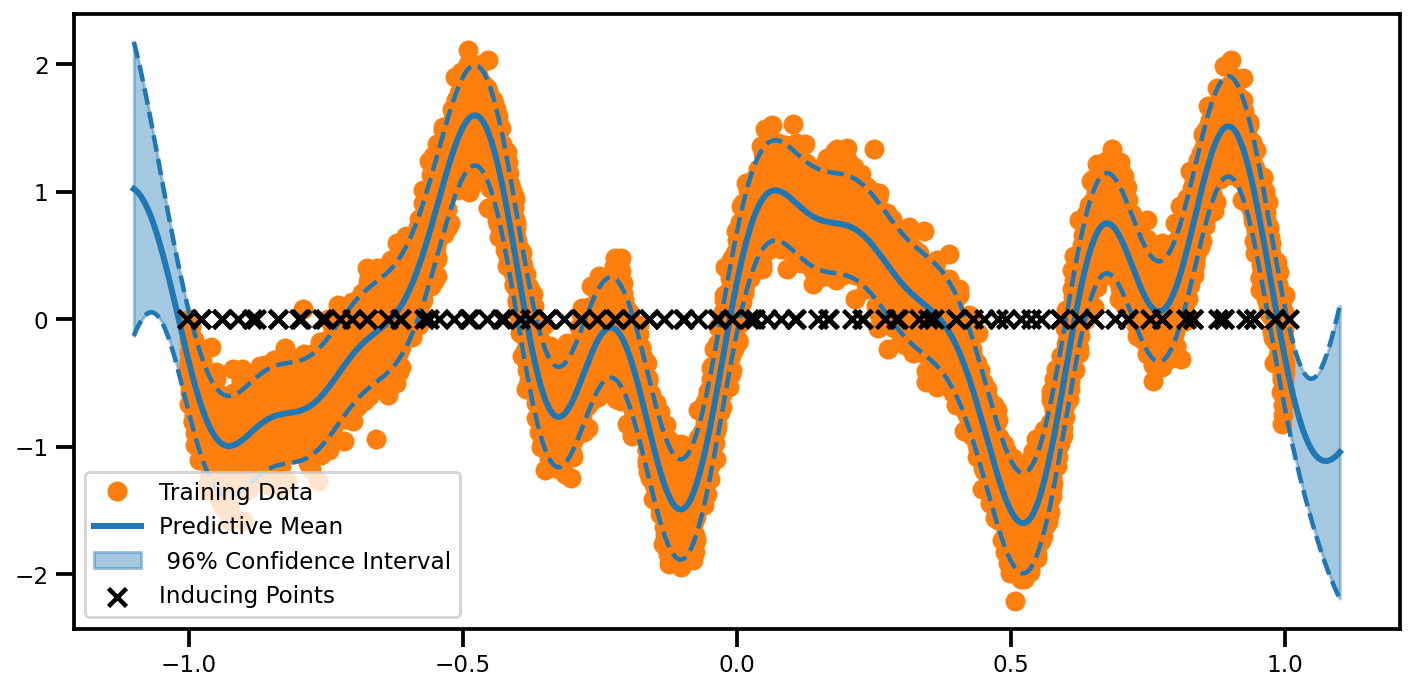

In [454]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(Xtrain, ytrain.squeeze(), "o", color="tab:orange", label="Training Data")
ax.plot(xtest, mu.ravel(), color="tab:blue", linewidth=3, label="Predictive Mean")
ax.fill_between(
    xtest.ravel(),
    mu.ravel() - one_stddev,
    mu.ravel() + one_stddev,
    alpha=0.4,
    color="tab:blue",
    label=f" {ci_prnt}% Confidence Interval",
)
plt.scatter(
    learned_params["x_u"],
    np.zeros_like(learned_params["x_u"]),
    label="Inducing Points",
    color="black",
    marker="x",
    zorder=3,
)
ax.plot(xtest, mu.ravel() - one_stddev, linestyle="--", color="tab:blue")
ax.plot(xtest, mu.ravel() + one_stddev, linestyle="--", color="tab:blue")
plt.tight_layout()
plt.legend()

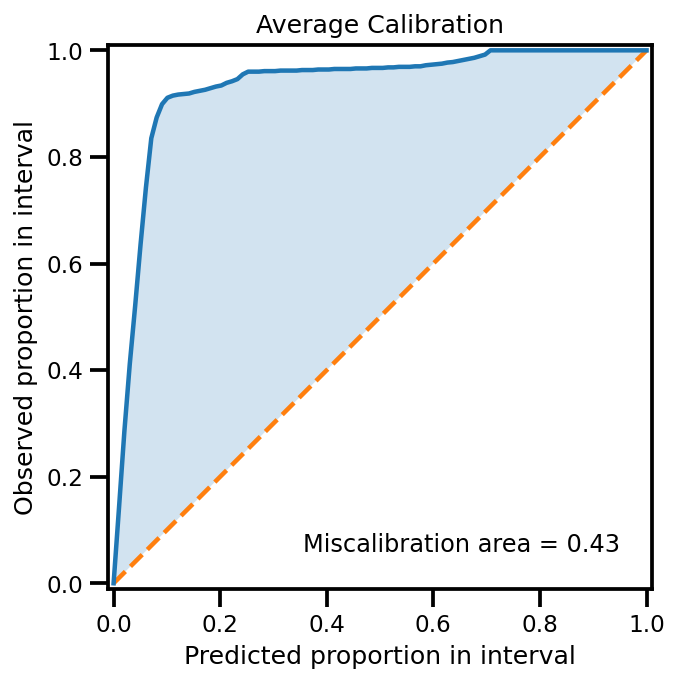

In [455]:
from uncertainty_toolbox import viz as utviz

utviz.plot_calibration(y_pred=mu.ravel(), y_std=std.ravel(), y_true=ytest.ravel())

In [ ]:




def SparseGP(X, y):

    n_samples = X.shape[0]
    # Set informative log-normal priors on kernel hyperparameters.
    # η = pm.HalfCauchy("η", beta=5)
    η = numpyro.sample("kernel_var", dist.HalfCauchy(scale=5.))
    ℓ = numpyro.sample("kernel_length", dist.Gamma(2., 1.))
    σ = numpyro.sample("sigma", dist.HalfCauchy(scale=5.))

    x_u = numpyro.param("x_u", init_value=x_u_init)

    # η = numpyro.param("kernel_var", init_value=1.0, constraints=dist.constraints.positive)
    # ℓ = numpyro.param("kernel_length", init_value=1.0,  constraints=dist.constraints.positive)
    # σ = numpyro.param("sigma", init_value=1.0, onstraints=dist.constraints.positive)

    

    # ================================
    # Qff Term
    # ================================
    # W   = (inv(Luu) @ Kuf).T
    # Qff = Kfu @ inv(Kuu) @ Kuf
    # Qff = W @ W.T
    # ================================
    Kuu = rbf_kernel(x_u, x_u, η, ℓ)
    Kuf = rbf_kernel(x_u, X, η, ℓ)
    Kuu += jnp.eye(Ninducing) * 1e-5#jax.ops.index_add(Kuu, Ninducing, 1e-5)
    # print(Kuu.min(), Kuu.max())
    Luu = jnp.linalg.cholesky(Kuu)
    # print(Luu.min(), Luu.max())
    # print(Luu.shape)
    W = jax.scipy.linalg.solve_triangular(Luu, Kuf, lower=True).T

    # print(W.shape)

    # Luu = jax.scipy.linalg.cho_factor(Kuu, lower=True)
    # W = jax.scipy.linalg.cho_solve(Luu, Kuf).T

    # ================================
    # Likelihood Noise Term
    # ================================
    # D = noise
    # ================================
    D = jnp.ones(n_samples) * σ
    
    # ================================
    # trace term
    # ================================
    # t = tr(Kff - Qff) / noise
    # t = - t / 2.0
    # ================================
    Kffdiag = jnp.diag(rbf_kernel(X, X, η, ℓ))
    # print(Kffdiag.min(), Kffdiag.max())
    Qffdiag = jnp.power(W, 2).sum(axis=1)
    # print(Qffdiag.min(), Qffdiag.max())
    trace_term = (Kffdiag - Qffdiag).sum() / σ
    trace_term = jnp.clip(trace_term, a_min=0.0)  # numerical errors
    # print(trace_term)
    numpyro.factor("trace_term", - trace_term/2.0)

    # ================================
    # Mean Function
    # ================================
    f_loc = np.zeros(n_samples)



    # Sample y according SGP
    return numpyro.sample("y", dist.LowRankMultivariateNormal(
        loc=f_loc, cov_factor=W, cov_diag=D)
        .expand_by(y.shape[:-1]).to_event(y.ndim - 1), 
        obs=y
    )


def empty_guide(X, y):
    pass

In [ ]:
with numpyro.handlers.seed(rng_seed=123):
    t = SparseGP(x, y.T)

print(t.shape)

(1, 1000)


In [ ]:
from numpyro.infer.autoguide import AutoDelta

sgp_model = SparseGP
guide = AutoDelta(sgp_model)

In [ ]:
y.shape, x.shape

((1000, 1), (1000, 1))

In [ ]:


# reproducibility
rng_key = random.PRNGKey(0)


n_epochs = 2_500

# Setup
optimizer = numpyro.optim.Adam(step_size=0.005)
# optimizer = numpyro.optim.Minimize()

svi = SVI(sgp_model, guide, optimizer, loss=Trace_ELBO())
svi_results = svi.run(random.PRNGKey(1), n_epochs, x, y.T)

100%|██████████| 2500/2500 [00:27<00:00, 89.43it/s, init loss: 2013.5096, avg. loss [2376-2500]: -53.4051]


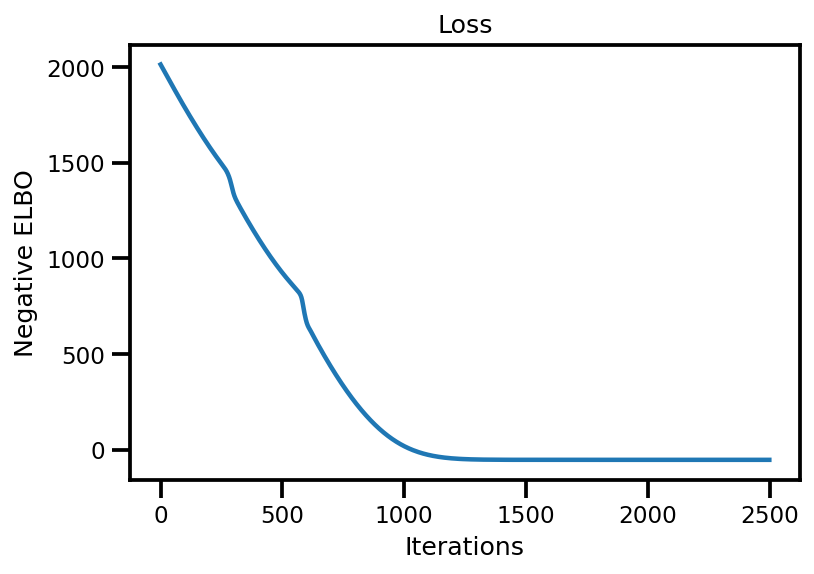

In [ ]:
fig, ax = plt.subplots()

ax.plot(svi_results.losses);
ax.set(
    title = "Loss",
    xlabel="Iterations",
    ylabel="Negative ELBO"
    );
plt.show()

In [ ]:
def concat_dictionaries(a: dict, b: dict) -> dict:
    """
    Append one dictionary below another. If duplicate keys exist, then the key-value pair of the second supplied
    dictionary will be used.
    """
    return {**a, **b}

In [ ]:
from pprint import pprint
# Take them directly
learned_params = svi_results.params
pprint(learned_params)

# Take them directly
median_params = guide.median(learned_params)
learned_params = concat_dictionaries(learned_params, median_params)
pprint(learned_params)

{'kernel_length_auto_loc': DeviceArray(0.108, dtype=float32),
 'kernel_var_auto_loc': DeviceArray(0.877, dtype=float32),
 'sigma_auto_loc': DeviceArray(0.044, dtype=float32),
 'x_u': DeviceArray([[ 0.462],
             [ 0.17 ],
             [ 0.266],
             [ 0.667],
             [-0.537],
             [ 0.562],
             [ 0.878],
             [-0.755],
             [-0.868],
             [-0.328],
             [-0.963],
             [-0.645],
             [-0.124],
             [ 0.969],
             [ 0.073],
             [ 0.774],
             [-0.226],
             [-0.025],
             [-0.43 ],
             [ 0.364]], dtype=float32)}
{'kernel_length': DeviceArray(0.108, dtype=float32),
 'kernel_length_auto_loc': DeviceArray(0.108, dtype=float32),
 'kernel_var': DeviceArray(0.877, dtype=float32),
 'kernel_var_auto_loc': DeviceArray(0.877, dtype=float32),
 'sigma': DeviceArray(0.044, dtype=float32),
 'sigma_auto_loc': DeviceArray(0.044, dtype=float32),
 'x_u': DeviceArr

#### Predictions

In [ ]:
from chex import Array
from copy import deepcopy

def sparse_cholesky_factorization(
    learned_params: dict,
    x: Array, y: Array, 
    jitter: 1e-5
    ) -> dict:

    params = deepcopy(learned_params)
    n_samples = x.shape[0]
    m_samples = learned_params["x_u"].shape[0]
    jitter = 1e-5

    # calculate the cholesky factorization
    Kuu = rbf_kernel(
        params["x_u"], 
        params["x_u"], 
        params["kernel_var"], 
        params["kernel_length"]
        )
    Kuu += np.eye(m_samples) * jitter
    Luu = jnp.linalg.cholesky(Kuu)

    Kuf = rbf_kernel(
        params["x_u"], x,
        params["kernel_var"], 
        params["kernel_length"]
        )

    W = jax.scipy.linalg.solve_triangular(Luu, Kuf, lower=True)
    D = np.ones(n_samples) * params["sigma"]

    W_Dinv = W / D
    K = W_Dinv @ W.T
    K = jax.ops.index_add(K, Ninducing, 1.0)

    L = jnp.linalg.cholesky(K)

    # mean function
    y_residual = y # mean function
    y_2D = y_residual.reshape(-1, n_samples).T
    W_Dinv_y = W_Dinv @ y_2D

    params["Luu"] = Luu
    params["W_Dinv_y"] = W_Dinv_y
    params["L"] = L
    params["y_shape"] = y.shape[:-1]

    return params



In [ ]:
params = sparse_cholesky_factorization(learned_params, x, y.T, jitter=1e-5)

In [ ]:
def _pred_factorize(params, xtest):

    Kux = rbf_kernel(
        params["x_u"],
        xtest,
        params["kernel_var"],
        params["kernel_length"]
    )
    Ws = jax.scipy.linalg.solve_triangular(
        params["Luu"], Kux, lower=True
    )
    # pack
    pack = jnp.concatenate(
        [params["W_Dinv_y"], Ws],
        axis=1
    )
    Linv_pack = jax.scipy.linalg.solve_triangular(
        params["L"], pack, lower=True
    )
    # unpack
    Linv_W_Dinv_y = Linv_pack[:, :params["W_Dinv_y"].shape[1]]
    Linv_Ws = Linv_pack[:, params["W_Dinv_y"].shape[1]:]

    return Ws, Linv_W_Dinv_y, Linv_Ws


def sparse_predict_mean(params: dict, xtest: Array)-> Array:
    n_test_samples = xtest.shape[0]
    _, Linv_W_Dinv_y, Linv_Ws = _pred_factorize(params, xtest)

    loc_shape = params["y_shape"] + (n_test_samples,)
    loc = (Linv_W_Dinv_y.T @ Linv_Ws).reshape(loc_shape)

    return loc.squeeze()


In [ ]:
mu = sparse_predict_mean(params, xtest)

In [ ]:
def sparse_predict_covariance(params: dict, xtest: Array, noiseless: bool=False)-> Array:

    n_test_samples = xtest.shape[0]

    Ws, Linv_W_Dinv_y, Linv_Ws = _pred_factorize(params, xtest)

    Kxx = rbf_kernel(
        xtest,
        xtest,
        params["kernel_var"],
        params["kernel_length"]
    )

    if not noiseless:
        Kxx += jnp.eye(n_test_samples) * params["sigma"] #jax.ops.index_add(Kxx, n_test_samples, params["sigma"])

    Qss = Ws.T @ Ws

    cov = Kxx - Qss + Linv_Ws.T @ Linv_Ws

    cov_shape = params["y_shape"] + (n_test_samples, n_test_samples)
    cov = np.reshape(cov, cov_shape)

    return cov

def sparse_predict_variance(params: dict, xtest: Array, noiseless: bool=False)-> Array:

    n_test_samples = xtest.shape[0]
    Ws, Linv_W_Dinv_y, Linv_Ws = _pred_factorize(params, xtest)
    # TODO: have the kernel function have this property
    Kxxdiag = jnp.diag(
        rbf_kernel(
        xtest,
        xtest,
        params["kernel_var"],
        params["kernel_length"]
    ))
    if not noiseless:
        Kxxdiag += jnp.ones(n_test_samples) * params["sigma"] #jax.ops.index_add(Kxxdiag, n_test_samples, params["sigma"])

    Qssdiag = jnp.power(Ws, 2).sum(axis=0)

    var = Kxxdiag - Qssdiag + jnp.power(Linv_Ws, 2).sum(axis=0)

    var_shape = params["y_shape"] + (n_test_samples,)
    var = np.reshape(var, var_shape)

    return var

In [ ]:
mu = sparse_predict_mean(params, xtest)
cov = sparse_predict_covariance(params, xtest, noiseless=False)
var = sparse_predict_variance(params, xtest, noiseless=False)

one_stddev = 1.96 * jnp.sqrt(np.diag(cov.squeeze()))
one_stddev_ = 1.96 * jnp.sqrt(var.squeeze())
# chex.assert_tree_all_close(one_stddev, one_stddev_)

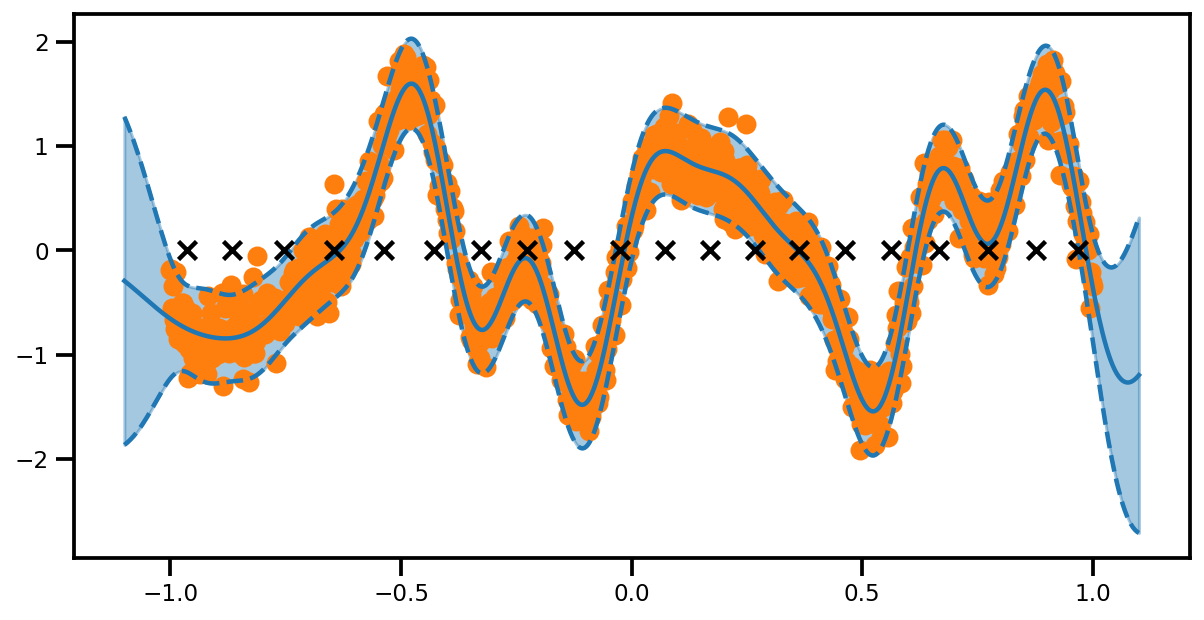

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y.squeeze(), "o", color="tab:orange")
ax.plot(xtest, mu.ravel(), color="tab:blue")
ax.fill_between(
    xtest.ravel(),
    mu.ravel() - one_stddev,
    mu.ravel() + one_stddev,
    alpha=0.4,
    color="tab:blue",
)
plt.scatter(learned_params["x_u"], np.zeros(Ninducing), 
            label="Inducing Points", color="black", marker="x",
            zorder=3
            )
ax.plot(xtest, mu.ravel() - one_stddev_, linestyle="--", color="tab:blue")
ax.plot(xtest, mu.ravel() + one_stddev_, linestyle="--", color="tab:blue")
plt.show()

### Uncertain Inputs

In [ ]:
input_var = jnp.array([0.001])
input_cov = input_var.reshape(-1, 1)

In [ ]:

xtest = jnp.linspace(-1.1, 1.1, 1_000).reshape(-1, 1)
ytest = f(xtest)

xtest_noise = xtest + input_var * jax.random.normal(key, shape=xtest.shape)
xtest_noise = np.sort(xtest_noise)
ytest_noise = f(xtest_noise)


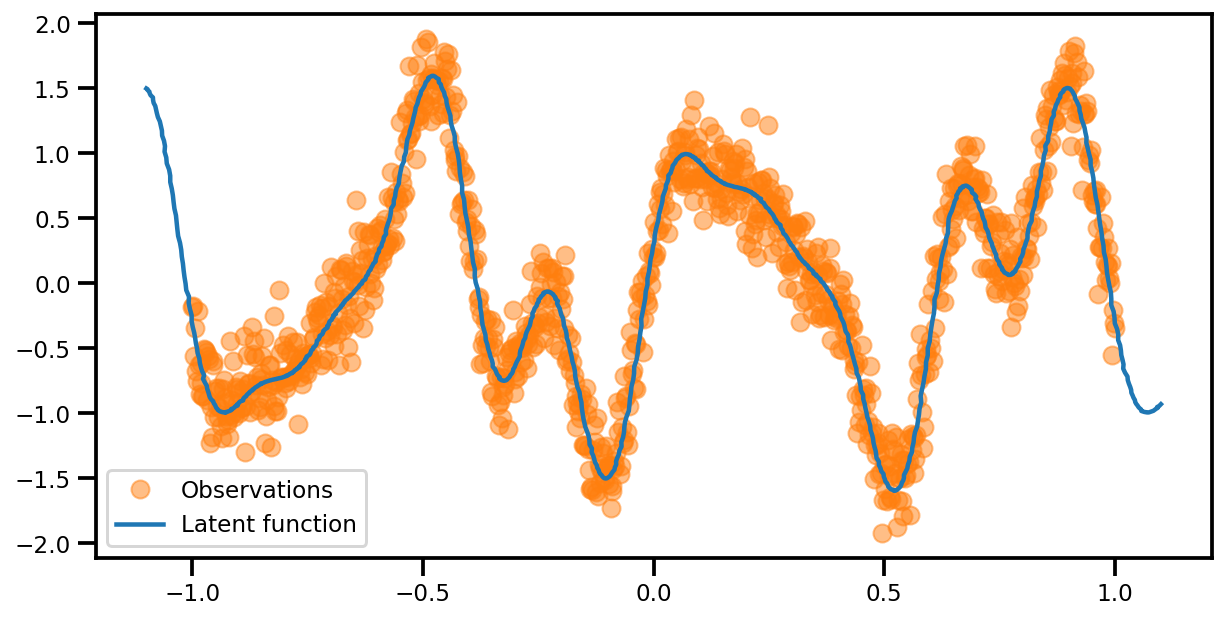

In [ ]:

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y, "o", label="Observations", color="tab:orange", alpha=0.5)
ax.plot(xtest_noise, ytest, label="Latent function", color="tab:blue")
ax.legend(loc="best")
plt.show()

In [ ]:
mu = sparse_predict_mean(params, xtest)
var = sparse_predict_variance(params, xtest, noiseless=False)

# gradient predictive mean
sparse_predict_mean_grad = jax.vmap(jax.grad(sparse_predict_mean, argnums=1), in_axes=(None, 0))

# predictive mean
dmu = sparse_predict_mean_grad(params, xtest)

# predictive variance
var_to1 = jnp.diag(dmu @ input_cov @ dmu.T)
one_stddev_to1 = 1.96 * jnp.sqrt(var.squeeze() + var_to1.squeeze())
# cov = sparse_predict_covariance(params, xtest, noiseless=False)
# var = sparse_predict_variance(params, xtest, noiseless=False)

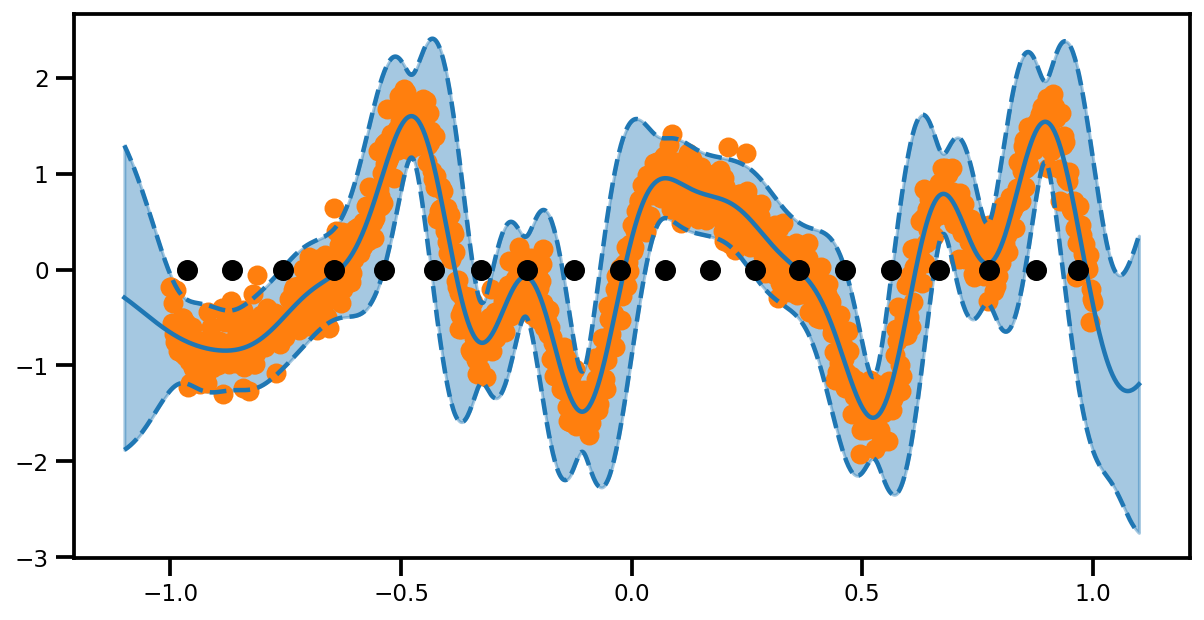

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y.squeeze(), "o", color="tab:orange")
ax.plot(xtest, mu.ravel(), color="tab:blue")
ax.fill_between(
    xtest.ravel(),
    mu.ravel() - one_stddev_to1,
    mu.ravel() + one_stddev_to1,
    alpha=0.4,
    color="tab:blue",
)
plt.scatter(learned_params["x_u"], np.zeros(Ninducing), 
            label="Inducing Points", color="black", zorder=3
            )
ax.plot(xtest, mu.ravel() - one_stddev_to1, linestyle="--", color="tab:blue")
ax.plot(xtest, mu.ravel() + one_stddev_to1, linestyle="--", color="tab:blue")
plt.show()